# Pentagons (single regular polygon)

We define some scripts to create the cutting patterns that show how
pentagons alone cannot tesselate the plane.<br>


### Strategy

- We define a basic shape using python library [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).<br>
- We fill a portion of the plane with copies of this shape.
- We remove the polygons outside the frame which defines the shape of the riser
- We use the **Shapely** set operation "difference" to trip shapes too close to the edge (leaving some margin for welding the risers)


### Process Overview

<img src="./img/process_overview.png" width="80%">

In [2]:
# Imports
import math
from math import cos, sin, tan

from shapely.geometry import Polygon, box
from shapely import affinity, centroid, polygons

import svgwrite
from svgwrite import mm

import matplotlib.pyplot as plt
import numpy as np

In [3]:
import sys
sys.path.append('../..')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    plot_polygon_list,
    blue_plot,
    center_rectangle_on_polygons,
    is_polygon_inside_frame,
    save_polygon_list_to_svg
)

## FUNCTION DEFINITIONS

### Canvas and Polygon sizes

In [4]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 176.5
tabica_width = 904.5

INSET_DISTANCE = 3.3   # X ratio gives gaps of about 2Xmm solid channels

band_width = 28 # solid margin, at top of step
side_inset = 22 # solid margin for sides of step

polygon_radius = 24 #24 

### Polygon creation

#### STAR 

In [5]:
# Create a 5-pointed star
from shapely.geometry import Polygon

def create_star_polygon(cx, cy, outer_radius, inner_radius):
    points = []
    for i in range(10):
        angle = math.pi * i / 5
        radius = outer_radius if i % 2 == 0 else inner_radius
        x = cx + radius * cos(angle)
        y = cy + radius * sin(angle)
        points.append((x, y))
    return Polygon(points)

alpha = math.pi/5
R = polygon_radius  # radius of the polygon
r1 = 2*R*sin(alpha/2) # small radius
r2 = 2*R*(cos(alpha)*(cos(alpha/2)*tan(alpha)+ sin(alpha/2))) # large radius
# Create star with outer radius matching polygon_radius and inner radius at 0.4 of outer
star = create_star_polygon(0, 0, r2, r1)
L = 2*R*sin(alpha) # side of the pentagon


## Parameters
<img src="./img/parameters.png" width="400px">

In [6]:
alpha = math.pi/5
R = polygon_radius  # radius of the polygon

a = R*cos(2*alpha)
b = R*sin(2*alpha)
c = R - a
h = R*cos(alpha)
l = R*sin(alpha)
L = 2*R*sin(alpha) # side of the pentagaon

r1 = 2*R*sin(alpha/2) # small radius
r2 = 2*R*(cos(alpha)*(cos(alpha/2)*tan(alpha)+ sin(alpha/2))) # large radius

x = 2*R*cos(alpha)*sin(alpha/2)
y = 2*R*sin(alpha)*sin(alpha/2)
z = 2*R*sin(alpha)*cos(alpha/2)


# Create star with outer radius matching polygon_radius and inner radius at 0.4 of outer
star = create_star_polygon(0, 0, r2, r1)
L = 2*R*sin(alpha) # side of the pentagon


In [7]:
# Create a square (4 sides)
hexagon = create_regular_polygon(0,0, R, 5)

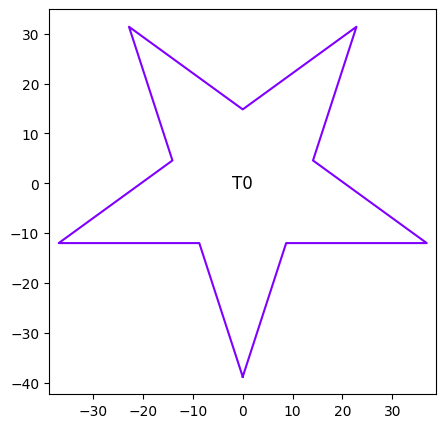

In [8]:
rotated_star = affinity.rotate(star, -90, origin="centroid")
polygon_dict = {}
polygon_dict['T0'] = rotated_star
plot_polygon_dict(polygon_dict)

### Dictionary of Polygons

Here we save a dictionary of polygons.

The reason for using a dictionary is to be able to plot polygon with its key representing its label.
This allows us to easily visualize the transforms that define the position of the polygon.

In [ ]:
down_star = affinity.rotate(star, -90, origin="centroid")
down_polygon = affinity.rotate(hexagon, -90, origin="centroid")
up_polygon = affinity.rotate(hexagon, 90, origin="centroid")

td1 = (L + R*sin(2*alpha) + r1*sin(alpha), R*cos(2*alpha) + L*sin(alpha/2)/tan(alpha))

# polygon diagonal translations
pd = {1: (b + L/2, a-h),
      2: (b, a + R),
      3: (b, -c-2*h),
      4: (b, R + 2*a + h)}


polygon_dict = {}

polygon_dict['T0'] = up_polygon

polygon_dict['T1'] = affinity.translate(down_star, td1[0], td1[1])

for n in range(1,4):
    dict_index = f"P{n}"
    polygon_dict[dict_index] = affinity.translate(down_polygon,pd[n][0],pd[n][1])
    # polygon_dict['P2'] = affinity.translate(down_polygon,pd2[0],pd2[1])
    # polygon_dict['P3'] = affinity.translate(down_polygon,pd3[0],pd3[1])
    # polygon_dict['P4'] = affinity.translate(down_polygon,pd4[0],pd4[1])
                                  

# polygon_dict['T3'] = affinity.translate(up_polygon,
#                                   -pentagon_horizontal_step_large,
#                                   +pentagon_vertical_step) 



# polygon_dict['T4'] = affinity.translate(down_polygon, 
#                                         +pentagon_horizontal_step_large,
#                                         -R*math.cos(2*alpha) - R*math.cos(alpha))

# polygon_dict['T5'] = affinity.translate(down_polygon, 
#                                         -pentagon_horizontal_step_large,
#                                         -R*math.cos(2*alpha) - R*math.cos(alpha))



# polygon_dict['T6'] = affinity.translate(down_polygon, 
#                                         +pentagon_horizontal_step_large + 2*R*math.sin(2*alpha),
#                                        -R*math.cos(2*alpha) - R*math.cos(alpha))        


### Plotting Dictionaries of Shapes

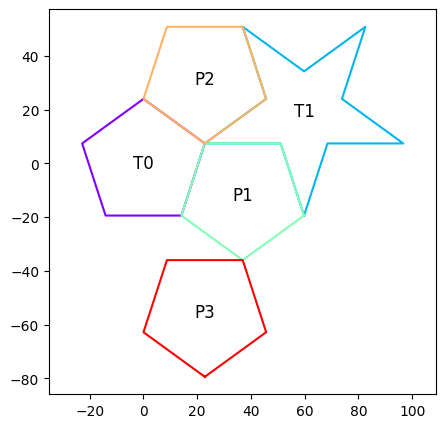

In [23]:
plot_polygon_dict(polygon_dict)

## List of Polygons

In order to generate the full list of polygons that fill the plane, we will store them in a list
instead of a dictionary.  <br>The basic idea is to use the basic initial shape
and apply a series of translations to generate the full list of polygons.

In [15]:
polygon_dict = {}
polygon_dict['T0'] = rotated_polygon
initial_polygon_list = list(polygon_dict.values())

### Plane Translations

We define 2 translations
- **up_t:** For *up* triangles
- **down_t:** For *down* triangles 


In [16]:
def translate_polygon(initial_polygon_list, x, y):
    translated_polygon = affinity.translate(initial_polygon_list, 
                                            + x * polygon_radius,
                                            + y * polygon_radius)
    return translated_polygon

### Plotting Lists of Polygons

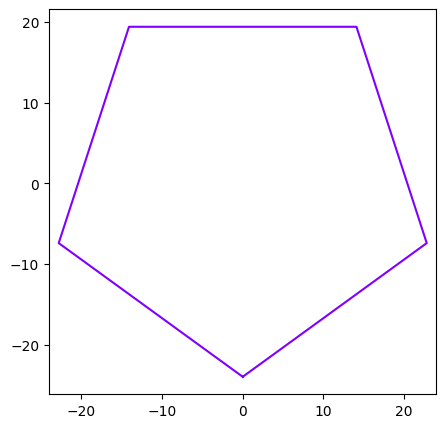

In [17]:
initial_polygon_list = list(polygon_dict.values())
plot_polygon_list(initial_polygon_list)

### Translation Strategy

In [ ]:
polygon_dict = {}
polygon_dict['T0'] = rotated_polygon
initial_polygon_list = list(polygon_dict.values())
full_polygon_list = [rotated_polygon]
first_row = []



for x in range(1,60):
    # create the first column
    first_column = []
    for y in range(0,6):
        new_polygon = affinity.translate(rotated_polygon, 
                                        +0*2*x*polygon_radius,
                                        +2*y*polygon_radius)
        first_column.append(new_polygon)

    # create the second column
    if x % 2 != 0:
        new_column = [affinity.translate(poly, x*polygon_radius, polygon_radius) for poly in first_column]
    else:
        new_column = [affinity.translate(poly, x*polygon_radius, 0) for poly in first_column]
    
    full_polygon_list.extend(new_column)

plot_polygon_list(full_polygon_list)


NameError: name 'rotated_polygon' is not defined

# FRAME

The frame defines the rectangle that will become the cut sheet metal.
We want to delete polygons outside of this frame, and potentially "trim" some of the polygons at the edges,
to ensure the sheet metal can we welded robustly to the next piece.

In [523]:
frame = polygons([[0,0],
                  [0 + tabica_width, 0],
                  [0 + tabica_width, 0 + tabica_height],
                  [0, 0 + tabica_height]])

### Function to center frame around the polygons

In [524]:
# Center the rectangle
centered_frame = center_rectangle_on_polygons(full_polygon_list, frame)

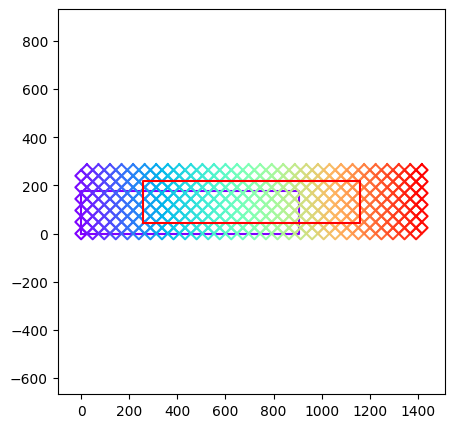

In [525]:
plot_polygon_list([frame] + full_polygon_list + [centered_frame])

### Delete polygons *mostly* outside of frame

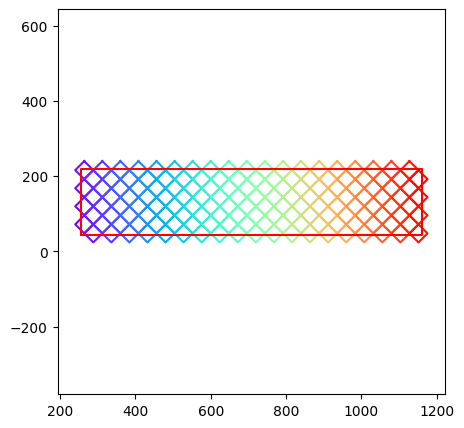

In [526]:
# Filter the full_polygon_list to keep only polygons "mostly" inside the rectangle
# by "mostly" we mean that the centroid of the polygon lies outside the frame.
filtered_polygon_list = [polygon for polygon in full_polygon_list if is_polygon_inside_frame(polygon, centered_frame)]

# Update the full_polygon_list
full_polygon_list = filtered_polygon_list

# Plot the polygons
plot_polygon_list(full_polygon_list + [centered_frame])

## Perform Inset Operation on polygons
This shrinks each polygon to leave some material between them by a specified amount

In [527]:
inset_polygon_list = []
for poly in full_polygon_list:
    inset_polygon_list.append(poly.buffer(-INSET_DISTANCE))



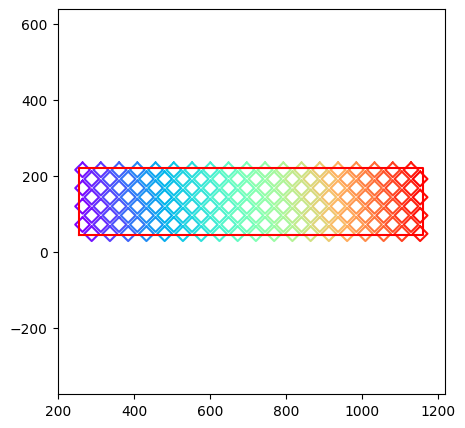

In [528]:
plot_polygon_list(inset_polygon_list + [centered_frame])

## Creating a border with margin  

1. We define some bands around the frame

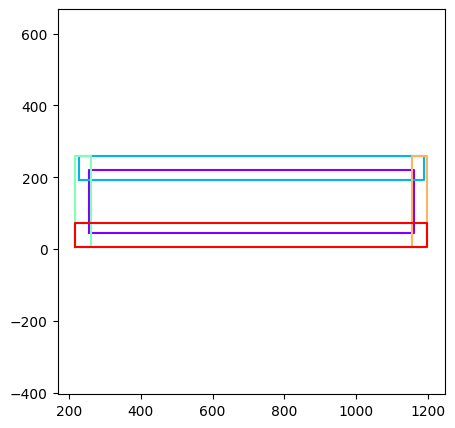

In [529]:

top_band = polygons([[centered_frame.bounds[0] - band_width, centered_frame.bounds[3] - band_width],
                    [centered_frame.bounds[0] - band_width, centered_frame.bounds[3] + band_width + 10],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] + band_width + 10],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] - band_width]])

left_band = polygons([[centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] - band_width - 10],
                      [centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[0] + band_width - side_inset, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[0] + band_width - side_inset, centered_frame.bounds[1] - band_width - 10]])

right_band = polygons([[centered_frame.bounds[2] - band_width + side_inset, centered_frame.bounds[1] - band_width - 10],
                      [centered_frame.bounds[2] - band_width + side_inset, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] - band_width - 10]])

bottom_band = polygons([[centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] - band_width - 10],
                        [centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] - band_width - 10]])

plot_polygon_list([centered_frame, top_band, left_band, right_band, bottom_band])

In [530]:
def is_point_inside_rectangle(point, rect):
    """Check if a point is inside a rectangle."""
    x, y = point
    (rx1, ry1, rx2, ry2) = rect.bounds
    return rx1 <= x <= rx2 and ry1 <= y <= ry2

def is_polygon_inside_rectangle(polygon, rect):
    """Check if any vertices of a polygon are inside a rectangle."""
    return any(is_point_inside_rectangle(vertex, rect) for vertex in polygon.exterior.coords)

In [531]:
top_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, top_band)]
left_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, left_band)]
right_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, right_band)]
bottom_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, bottom_band)]

# deduplicate the list of polygons overlapped by each band:
band_polygons = list(set(top_band_polygons + left_band_polygons + right_band_polygons + bottom_band_polygons))
# keep the polygons outside of bands for later:
all_other_polygons = [polygon for polygon in inset_polygon_list if polygon not in band_polygons]

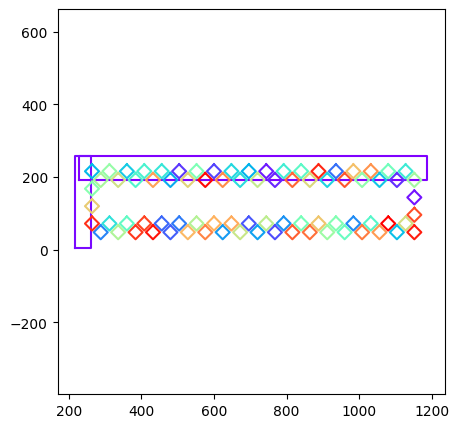

In [532]:
plot_polygon_list([top_band] + [left_band] + band_polygons)

In [533]:
cropped_polygons = []
for poly in band_polygons:
    bit_to_keep_t = poly.difference(top_band)
    bit_to_keep_b = bit_to_keep_t.difference(bottom_band)
    bit_to_keep_l = bit_to_keep_b.difference(left_band)
    bit_to_keep = bit_to_keep_l.difference(right_band)
    cropped_polygons.append(bit_to_keep)


# some polygons are cropped down to nothing (no coordinates), so we need to remove them
cropped_polygons = [poly for poly in cropped_polygons if poly.exterior] 

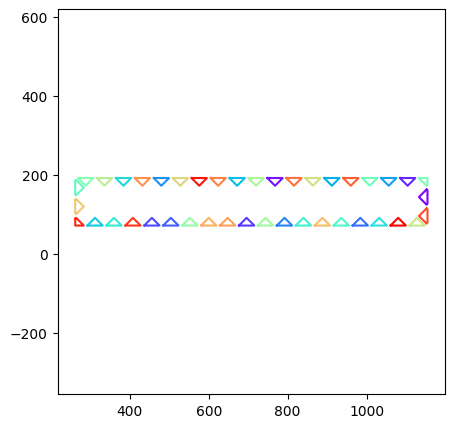

In [534]:
plot_polygon_list(cropped_polygons)

In [535]:
final_polygons =  all_other_polygons + cropped_polygons + [centered_frame]


# SANITY CHECKS

- delete any polygon with an area less than a threshold

In [536]:
len(final_polygons)

115

In [537]:

for poly in final_polygons:
    # pop polygon out of the list if area < 9
    if poly.area < 8:
        final_polygons.remove(poly)
    

In [538]:
len(final_polygons)

115

### Save POLYGONS to SVG

# SAVE


In [539]:
save_polygon_list_to_svg(final_polygons, filename='tramo1.4.svg')

In [540]:
save_polygon_list_to_svg(full_polygon_list, filename='tramo1.4_draft.svg')

In [541]:
# Save as PNG
plt.figure(figsize=(12, 8))
for polygon in final_polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y, color='blue', linewidth=0.5)
plt.axis('equal')
plt.savefig('tramo1.4.png', dpi=300, bbox_inches='tight')
plt.close()


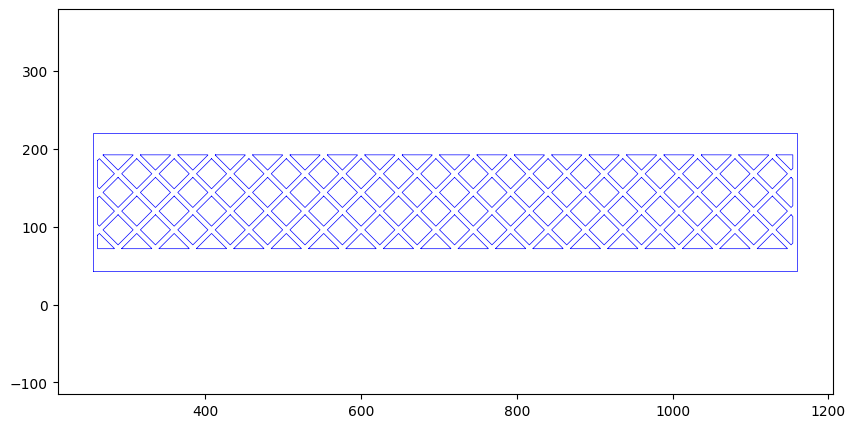

In [542]:
blue_plot(final_polygons)

In [543]:
import numpy as np
from polygon_duplicates import find_duplicate_polygons

# Your polygons as numpy arrays
polygons = [
    np.array([[0, 0], [1, 0], [1, 1], [0, 1]]),
    np.array([[1, 0], [1, 1], [0, 1], [0, 0]]),  # Same as first polygon but rotated
    np.array([[2, 2], [3, 2], [3, 3], [2, 3]])   # Different polygon
]

duplicates = find_duplicate_polygons(full_polygon_list)

In [544]:
duplicates

[]